In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
# rename columns for my sanity 
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# clean sentiment value names
sentiment_replace = {'Positive emotion': 'positive', 'Negative emotion': 'negative'}
df.sentiment.replace(sentiment_replace, inplace=True)

For now we'll work on just the positive and negative sentiment since a binary classifier is always easier.
Later We can see if we can classify neutral emotions as well.

In [8]:
df1 = df[(df.sentiment == 'positive') | 
         (df.sentiment == 'negative') ]

In [9]:
df1.sentiment.value_counts(normalize=True)

positive    0.839346
negative    0.160654
Name: sentiment, dtype: float64

The classes are very imbalanced so we'll have to 

In [10]:
df1.isna().sum()

text           0
product      357
sentiment      0
dtype: int64

In [11]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

We have some nulls in the product column. We probably won't make much use of that information anyway, so we'll drop that column and get back to it later.

In [12]:
corpus = df1.drop('product', axis=1)

Now that we have the data we need, we can start working on pre-processing the tweets so we can eventually run it through a model.

In [13]:
X = corpus.text
y = corpus.sentiment

In [14]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.probability import FreqDist

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [16]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [17]:
sw = stopwords.words('english')

In [24]:
def tweet_prep(tweet, stop_words=sw):
    '''
    
    :param doc: a document from the satire corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [25]:
token_tweets = [tweet_prep(tweet, sw) for tweet in X_train]

In [26]:
token_tweets[100]

'mike tyson launch iphone game mention sxsw link tech news link'

In [27]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(token_tweets)
X_test_vec = cv.transform(X_test)

In [28]:
df_cv = pd.DataFrame(X_train_vec.toarray(), columns=cv.get_feature_names())

In [34]:
df_cv.sum().sort_values(ascending=False)

sxsw       2804
mention    1859
ipad       1086
link        994
apple       799
           ... 
midway        1
midst         1
midem         1
midday        1
layer         1
Length: 4205, dtype: int64

In [35]:
# fdist = FreqDist(cv.get_feature_names())
# fdist = FreqDist(X_train_vec)
# plt.figure(figsize=(10, 10))
# fdist.plot(30);

## Modeling

### Dummy model

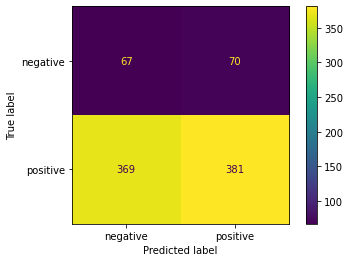

In [36]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='uniform', random_state=42)
dummy.fit(X_train_vec, y_train)
y_pred_dummy_sm = dummy.predict(X_test_vec)
plot_confusion_matrix(estimator=dummy, X=X_test_vec, y_true=y_test);

Our dummy model blindly predicts half positive half negative. So it has about 50% accuarcy.

We can work our way up from there.

We are accurate on 85.91% of our predictions.
We identified 25.55% of the negative tweets.


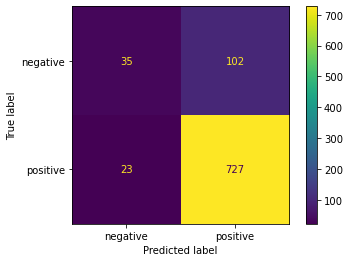

In [86]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_test_vec)
print(f'We are accurate on {100*round(accuracy_score(y_test, y_hat),4)}% of our predictions.')
mnb_cm = confusion_matrix(y_test, y_hat)
print(f'We identified {100*round(mnb_cm[0][0] / sum(mnb_cm[0]),4)}% of the negative tweets.')
plot_confusion_matrix(mnb, X_test_vec, y_test);

Getting 86% accuracy on our first try is great! However we think that the use of our model will be mainly in being able to identify the negative tweets, and in this area we only get 35/137 or 25%. Not good.

The reason our model is doing poorly is because of the class imbalance which we noted earlier. It is easy to be accurate overall since most tweets are positive, so our model is heavily weighted to positive. but it won't be able to identify the negative tweets as well. We need to fix the imbalance.

In [51]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm, y_train_sm = smote.fit_sample(X_train_vec, y_train) 

In [53]:
y_train_sm.value_counts()

positive    2228
negative    2228
Name: sentiment, dtype: int64


Now that the tweets are balanced, let's see how our model will do.

We are accurate on 80.38% of our predictions
We identified 56.93% of the negative tweets


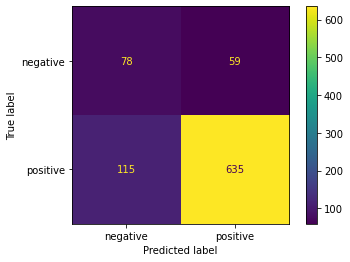

In [84]:
sm_mnb = MultinomialNB()
sm_mnb.fit(X_train_sm, y_train_sm)
sm_y_hat = sm_mnb.predict(X_test_vec)
print(f'We are accurate on {100*round(accuracy_score(y_test, sm_y_hat),4)}% of our predictions')
sm_cm = confusion_matrix(y_test, sm_y_hat)
print(f'We identified {100*round(sm_cm[0][0] / sum(sm_cm[0]),4)}% of the negative tweets')
plot_confusion_matrix(sm_mnb, X_test_vec, y_test);

We see that our accuracy went down a bit, but now we are much better at identifying the negative tweets. 
We can try a more sophisticated vectorizer, and also try using different classifying algorithms.

In [60]:
tfidf = TfidfVectorizer()
tfidf_X_train_ = tfidf.fit_transform(token_tweets)
tfidf_X_test = tfidf.transform(X_test)

In [61]:
smote2 = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm2, y_train_sm2 = smote.fit_sample(tfidf_X_train_, y_train) 

We are accurate on 80.27% of our predictions
We identified 61.309999999999995% of the negative tweets


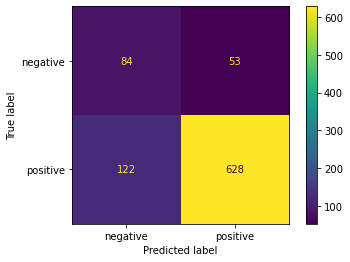

In [83]:
tfidf_mnb = MultinomialNB()
tfidf_mnb.fit(X_train_sm2, y_train_sm2)
tfidf_y_hat = tfidf_mnb.predict(tfidf_X_test)
print(f'We are accurate on {100*round(accuracy_score(y_test, tfidf_y_hat),4)}% of our predictions')
tfidf_cm = confusion_matrix(y_test, tfidf_y_hat)
plot_confusion_matrix(tfidf_mnb, tfidf_X_test, y_test);
print(f'We identified {100*round(tfidf_cm[0][0] / sum(tfidf_cm[0]),4)}% of the negative tweets')

With the TFIDF Vectorizer we were able to get even better on the negatives. Now we can try some other classifiers.